In [1]:
import cv2
import numpy as np
import mediapipe as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import deque
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 1. Data Loading
def load_data(csv_path):
    """Load the dataset from CSV file"""
    data = pd.read_csv(csv_path)
    print(f"Dataset loaded with {len(data)} samples")
    print("Class distribution:")
    print(data['label'].value_counts())
    return data

In [ ]:
# 2. Data Visualization
def visualize_landmarks(df, num_samples=3):
    """Visualize hand landmarks for random samples"""
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        sample = df.sample(1)
        label = sample['label'].values[0]
        landmarks = sample.iloc[:, :-1].values.reshape(21, 3)
        
        # 2D Plot
        ax = fig.add_subplot(2, num_samples, i+1)
        ax.scatter(landmarks[:, 0], landmarks[:, 1])
        ax.set_title(f'2D: {label}')
        ax.invert_yaxis()  
        
        # 3D Plot
        ax = fig.add_subplot(2, num_samples, i+num_samples+1, projection='3d')
        ax.scatter(landmarks[:, 0], landmarks[:, 1], landmarks[:, 2])
        ax.set_title(f'3D: {label}')
    
    plt.tight_layout()
    plt.savefig('landmarks_visualization.png')
    plt.show()

In [ ]:
# 3. Data Preprocessing
def preprocess_data(df):
    """Preprocess the landmark data"""
    X = df.iloc[:, :-1].values.reshape(-1, 21, 3)
    y = df.iloc[:, -1].values
    
    # Normalization
    processed_features = []
    for landmarks in X:
        wrist = landmarks[0]
        mid_finger = landmarks[9]
        
        # Center landmarks at wrist and normalize by mid-finger distance
        centered = landmarks - wrist
        scale = np.linalg.norm(mid_finger - wrist)
        if scale > 0:
            centered[:, :2] /= scale  
        
        # Flatten and add to features
        processed_features.append(centered.flatten())
    
    return np.array(processed_features), y

In [5]:
# 4. Model Training and Evaluation
def train_and_evaluate_models(X, y):
    """Train and evaluate multiple models"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Store results
        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "report": classification_report(y_test, y_pred, output_dict=True)
        }
        
        print(f"{name} Accuracy: {results[name]['accuracy']:.3f}")
        print(classification_report(y_test, y_pred))
    
    return models, results

In [ ]:
# 5. Real-time Gesture Recognition
def real_time_recognition(model, output_video_path='hand_gesture_output.avi'):
    """Run real-time gesture recognition using webcam"""
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, 
                          min_detection_confidence=0.7, min_tracking_confidence=0.5)
    mp_drawing = mp.solutions.drawing_utils
    
    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (640, 480))
    
    predictions_window = deque(maxlen=5)  
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract and preprocess landmarks
                landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                wrist = landmarks[0]
                mid_finger = landmarks[9]
                
                # Normalize landmarks
                centered = landmarks - wrist
                scale = np.linalg.norm(mid_finger - wrist)
                if scale > 0:
                    centered[:, :2] /= scale
                
                # Predict gesture
                features = centered.flatten().reshape(1, -1)
                pred = model.predict(features)[0]
                predictions_window.append(pred)
                
                # Stabilize prediction
                if len(predictions_window) > 0:
                    stabilized_pred = max(set(predictions_window), key=predictions_window.count)
                else:
                    stabilized_pred = pred
                
                # Draw landmarks and prediction
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                cv2.putText(frame, f"Gesture: {stabilized_pred}", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        out.write(frame)
        cv2.imshow('Hand Gesture Recognition', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Video saved at: {os.path.abspath(output_video_path)}")

Dataset loaded with 25675 samples
Class distribution:
label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


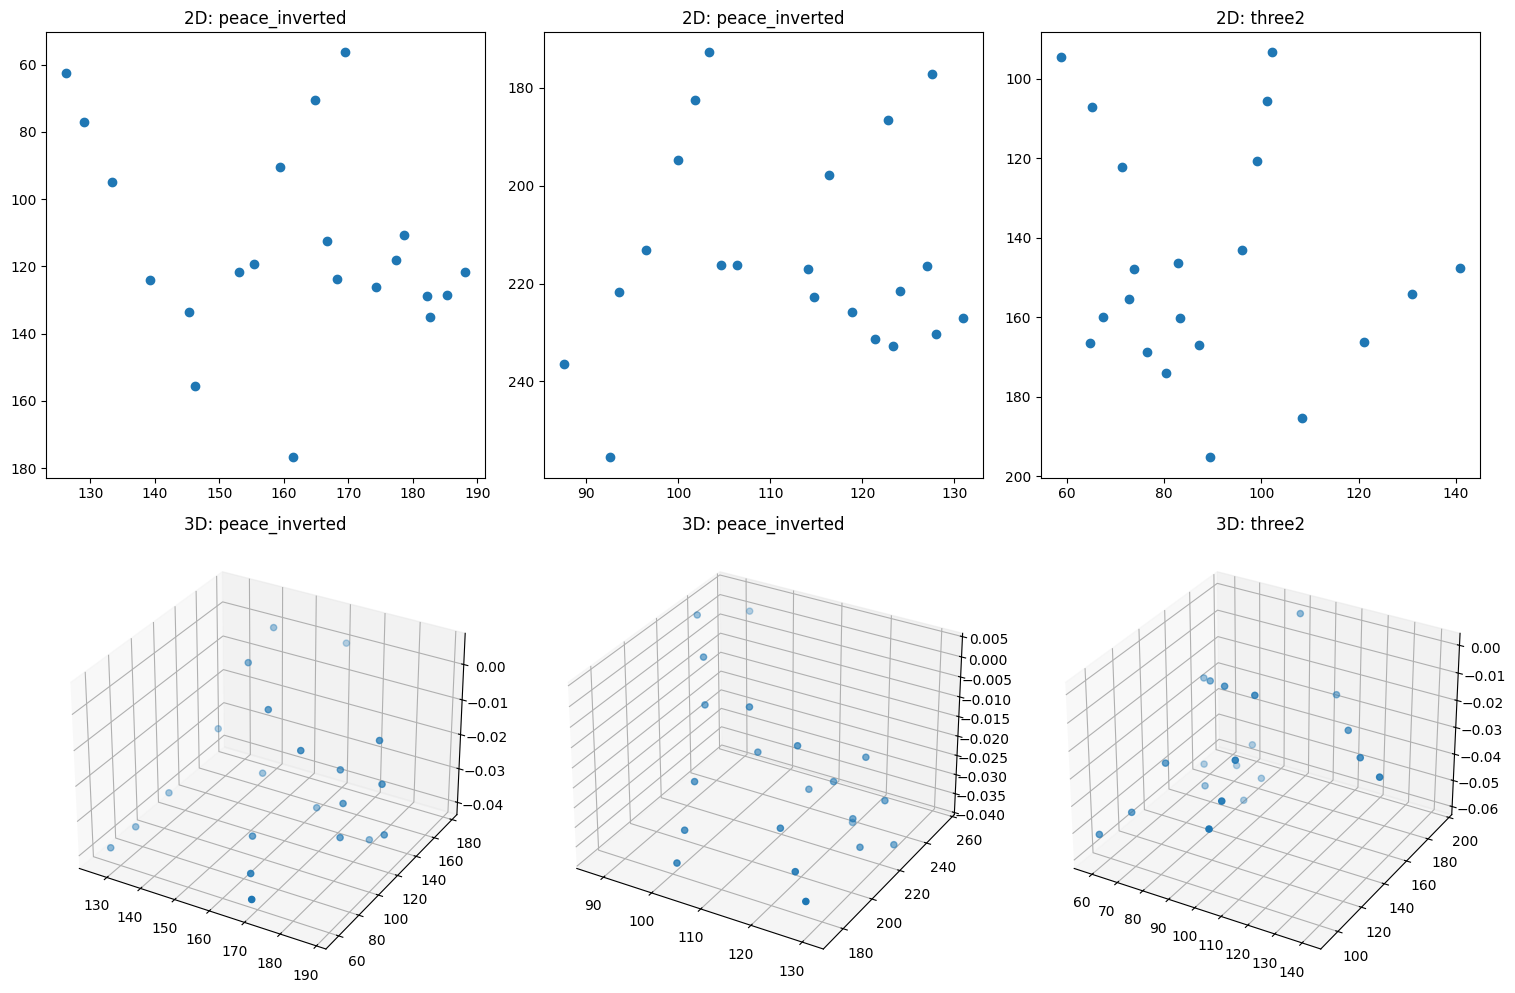


Training Random Forest...
Random Forest Accuracy: 0.976
                 precision    recall  f1-score   support

           call       0.98      0.99      0.99       287
        dislike       1.00      1.00      1.00       260
           fist       1.00      1.00      1.00       209
           four       0.96      0.97      0.96       325
           like       1.00      0.98      0.99       304
           mute       0.95      0.96      0.96       195
             ok       0.98      0.99      0.98       340
            one       0.96      0.96      0.96       248
           palm       0.99      0.98      0.98       317
          peace       0.95      0.95      0.95       276
 peace_inverted       0.98      0.96      0.97       307
           rock       0.99      0.99      0.99       290
           stop       0.95      0.98      0.97       293
  stop_inverted       0.98      0.98      0.98       309
          three       0.99      0.95      0.97       298
         three2       0.99    

In [ ]:
def main():
    # 1. Load data
    data = load_data('hand_landmarks_data.csv')  
    
    # 2. Visualize data
    visualize_landmarks(data)
    
    # 3. Preprocess data
    X, y = preprocess_data(data)
    
    # 4. Train and evaluate models
    models, results = train_and_evaluate_models(X, y)
    
    # Select best model (based on accuracy)
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model = models[best_model_name]
    print(f"\nSelected best model: {best_model_name}")
    
    # 5. Real-time recognition with best model
    real_time_recognition(best_model)

if __name__ == "__main__":
    main()